In [18]:
# import libraries
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import time
import os
import glob

# import plotly.graph_objects as go

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

plt.style.use("seaborn-bright")

<ipython-input-18-481bc5804a7b>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


In [2]:
# INTEGRATION METHODS

def bulirsch_stoer_3d(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # position = (x_n, y_n, z_n): the x, y and z position at time n
    # velocity = (Vx_n, Vy_n, Vz_n): the velocity vector components for x, y and z at time n
    # timestep: delta(t), interval of time between 2 approximations
    # F_x: the derivative function for x component of velocity
    # F_y: the derivation function for y component of velocity
    # F_z: the derivation function for z component of velocity
    # args_x: arguments to be passed to F_x (in addition to Vx, Vy, Vz, x, y, z)
    # args_y: arguments to be passed to F_y (in addition to Vx, Vy, Vz, x, y, z)
    # args_z: arguments to be passed to F_z (in addition to Vx, Vy, Vz, x, y, z)
    # N: number of steps for the modified midpoint method so that h = step_size = timestep/N
    # h: first step size to try for the midpoint method 
    # q: such that h/q is other step size to try for the midpoint method
    # p: for Richardson extrapolation, if p = 1: linear ...
    
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)


def bulirsch_stoer_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

def Richardson_extrapolation(f_h, f_hq, q, p):
    return f_h + (f_h - f_hq)/((q**(-p)) -1)

def modified_midpoint_method(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = []
    y_values = []
    z_values = []
    
    Vx_values = []
    Vy_values = []
    Vz_values = []
    
    Fx_values = []
    Fy_values = []
    Fz_values = []
    
    # prep
    x_values.append(position[0])
    y_values.append(position[1])
    z_values.append(position[2])
    
    Vx_values.append(velocity[0])
    Vy_values.append(velocity[1])
    Vz_values.append(velocity[2])
    
    Fx_values.append(Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fy_values.append(Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fz_values.append(Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    
    # step 1
    # print("step:", 1)
    x_values.append(x_values[0] + Vx_values[0] * h)
    y_values.append(y_values[0] + Vy_values[0] * h)
    z_values.append(z_values[0] + Vz_values[0] * h)

    Vx_values.append(Vx_values[0] + Fx_values[0] * h)
    Vy_values.append(Vy_values[0] + Fy_values[0] * h)
    Vz_values.append(Vz_values[0] + Fz_values[0] * h)

    Fx_values.append(Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fy_values.append(Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fz_values.append(Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values.append(x_values[n-2] + Vx_values[n-1] * 2 * h)
        y_values.append(y_values[n-2] + Vy_values[n-1] * 2 * h)
        z_values.append(z_values[n-2] + Vz_values[n-1] * 2 * h)

        Vx_values.append(Vx_values[n-2] + Fx_values[n-1] * 2 * h)
        Vy_values.append(Vy_values[n-2] + Fy_values[n-1] * 2 * h)
        Vz_values.append(Vz_values[n-2] + Fz_values[n-1] * 2 * h)

        Fx_values.append(Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
        Fy_values.append(Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
        Fz_values.append(Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n]))
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values

def modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = [None] * (N + 1)
    y_values = [None] * (N + 1)
    z_values = [None] * (N + 1)
    
    Vx_values = [None] * (N + 1)
    Vy_values = [None] * (N + 1)
    Vz_values = [None] * (N + 1)
    
    Fx_values = [None] * (N + 1)
    Fy_values = [None] * (N + 1)
    Fz_values = [None] * (N + 1)
    
    # prep
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 1
    # print("step:", 1)
    x_values[1] = x_values[0] + Vx_values[0] * h
    y_values[1] = y_values[0] + Vy_values[0] * h
    z_values[1] = z_values[0] + Vz_values[0] * h

    Vx_values[1] = Vx_values[0] + Fx_values[0] * h
    Vy_values[1] = Vy_values[0] + Fy_values[0] * h
    Vz_values[1] = Vz_values[0] + Fz_values[0] * h

    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values[n] = x_values[n-2] + Vx_values[n-1] * 2 * h
        y_values[n] = y_values[n-2] + Vy_values[n-1] * 2 * h
        z_values[n] = z_values[n-2] + Vz_values[n-1] * 2 * h

        Vx_values[n] = Vx_values[n-2] + Fx_values[n-1] * 2 * h
        Vy_values[n] = Vy_values[n-2] + Fy_values[n-1] * 2 * h
        Vz_values[n] = Vz_values[n-2] + Fz_values[n-1] * 2 * h

        Fx_values[n] = Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fy_values[n] = Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fz_values[n] = Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values

def runga_kutta_3d(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z):
    # position = (x_n, y_n, z_n): the x, y and z position at time n
    # velocity = (Vx_n, Vy_n, Vz_n): the velocity vector components for x, y and z at time n
    # timestep: delta(t), interval of time between 2 approximations
    # F_x: the derivative function for x component of velocity
    # F_y: the derivation function for y component of velocity
    # F_z: the derivation function for z component of velocity
    # args_x: arguments to be passed to F_x (in addition to Vx, Vy, Vz, x, y, z)
    # args_y: arguments to be passed to F_y (in addition to Vx, Vy, Vz, x, y, z)
    # args_z: arguments to be passed to F_z (in addition to Vx, Vy, Vz, x, y, z)
    
    x_values = []
    y_values = []
    z_values = []
    
    Vx_values = []
    Vy_values = []
    Vz_values = []
    
    Fx_values = []
    Fy_values = []
    Fz_values = []
    
    # step 1
    x_values.append(position[0])
    y_values.append(position[1])
    z_values.append(position[2])
    
    Vx_values.append(velocity[0])
    Vy_values.append(velocity[1])
    Vz_values.append(velocity[2])
    
    Fx_values.append(Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fy_values.append(Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    Fz_values.append(Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0]))
    
    # step 2
    x_values.append(x_values[0] + Vx_values[0] * timestep/2)
    y_values.append(y_values[0] + Vy_values[0] * timestep/2)
    z_values.append(z_values[0] + Vz_values[0] * timestep/2)
    
    Vx_values.append(Vx_values[0] + Fx_values[0] * timestep/2)
    Vy_values.append(Vy_values[0] + Fy_values[0] * timestep/2)
    Vz_values.append(Vz_values[0] + Fz_values[0] * timestep/2)
    
    Fx_values.append(Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fy_values.append(Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    Fz_values.append(Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1]))
    
    # step 3
    x_values.append(x_values[0] + Vx_values[1] * timestep/2)
    y_values.append(y_values[0] + Vy_values[1] * timestep/2)
    z_values.append(z_values[0] + Vz_values[1] * timestep/2)
    
    Vx_values.append(Vx_values[0] + Fx_values[1] * timestep/2)
    Vy_values.append(Vy_values[0] + Fy_values[1] * timestep/2)
    Vz_values.append(Vz_values[0] + Fz_values[1] * timestep/2)
    
    Fx_values.append(Fx(args_x, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2]))
    Fy_values.append(Fy(args_y, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2]))
    Fz_values.append(Fz(args_z, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2]))
    
    # step 4
    x_values.append(x_values[0] + Vx_values[2] * timestep)
    y_values.append(y_values[0] + Vy_values[2] * timestep)
    z_values.append(z_values[0] + Vz_values[2] * timestep)
    
    Vx_values.append(Vx_values[0] + Fx_values[2] * timestep)
    Vy_values.append(Vy_values[0] + Fy_values[2] * timestep)
    Vz_values.append(Vz_values[0] + Fz_values[2] * timestep)
    
    Fx_values.append(Fx(args_x, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3]))
    Fy_values.append(Fy(args_y, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3]))
    Fz_values.append(Fz(args_z, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3]))
    
    # step 5
    x_final = x_values[0] + ((Vx_values[0] + 2*Vx_values[1] + 2*Vx_values[2] + Vx_values[3])*timestep)/6
    y_final = y_values[0] + ((Vy_values[0] + 2*Vy_values[1] + 2*Vy_values[2] + Vy_values[3])*timestep)/6
    z_final = z_values[0] + ((Vz_values[0] + 2*Vz_values[1] + 2*Vz_values[2] + Vz_values[3])*timestep)/6
    
    Vx_final = Vx_values[0] + ((Fx_values[0] +2*Fx_values[1] +2*Fx_values[2] + Fx_values[3])*timestep)/6
    Vy_final = Vy_values[0] + ((Fy_values[0] +2*Fy_values[1] +2*Fy_values[2] + Fy_values[3])*timestep)/6
    Vz_final = Vz_values[0] + ((Fz_values[0] +2*Fz_values[1] +2*Fz_values[2] + Fz_values[3])*timestep)/6
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

def runga_kutta_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z):
    x_values = [None] * 4
    y_values = [None] * 4
    z_values = [None] * 4
    
    Vx_values = [None] * 4
    Vy_values = [None] * 4
    Vz_values = [None] * 4
    
    Fx_values = [None] * 4
    Fy_values = [None] * 4
    Fz_values = [None] * 4
    
    # step 1
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 2
    x_values[1] = x_values[0] + Vx_values[0] * timestep/2
    y_values[1] = y_values[0] + Vy_values[0] * timestep/2
    z_values[1] = z_values[0] + Vz_values[0] * timestep/2
    
    Vx_values[1] = Vx_values[0] + Fx_values[0] * timestep/2
    Vy_values[1] = Vy_values[0] + Fy_values[0] * timestep/2
    Vz_values[1] = Vz_values[0] + Fz_values[0] * timestep/2
    
    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    
    # step 3
    x_values[2] = x_values[0] + Vx_values[1] * timestep/2
    y_values[2] = y_values[0] + Vy_values[1] * timestep/2
    z_values[2] = z_values[0] + Vz_values[1] * timestep/2
    
    Vx_values[2] = Vx_values[0] + Fx_values[1] * timestep/2
    Vy_values[2] = Vy_values[0] + Fy_values[1] * timestep/2
    Vz_values[2] = Vz_values[0] + Fz_values[1] * timestep/2
    
    Fx_values[2] = Fx(args_x, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fy_values[2] = Fy(args_y, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fz_values[2] = Fz(args_z, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    
    # step 4
    x_values[3] = x_values[0] + Vx_values[2] * timestep
    y_values[3] = y_values[0] + Vy_values[2] * timestep
    z_values[3] = z_values[0] + Vz_values[2] * timestep
    
    Vx_values[3] = Vx_values[0] + Fx_values[2] * timestep
    Vy_values[3] = Vy_values[0] + Fy_values[2] * timestep
    Vz_values[3] = Vz_values[0] + Fz_values[2] * timestep
    
    Fx_values[3] = Fx(args_x, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fy_values[3] = Fy(args_y, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fz_values[3] = Fz(args_z, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    
    # step 5
    x_final = x_values[0] + ((Vx_values[0] + 2*Vx_values[1] + 2*Vx_values[2] + Vx_values[3])*timestep)/6
    y_final = y_values[0] + ((Vy_values[0] + 2*Vy_values[1] + 2*Vy_values[2] + Vy_values[3])*timestep)/6
    z_final = z_values[0] + ((Vz_values[0] + 2*Vz_values[1] + 2*Vz_values[2] + Vz_values[3])*timestep)/6
    
    Vx_final = Vx_values[0] + ((Fx_values[0] +2*Fx_values[1] +2*Fx_values[2] + Fx_values[3])*timestep)/6
    Vy_final = Vy_values[0] + ((Fy_values[0] +2*Fy_values[1] +2*Fy_values[2] + Fy_values[3])*timestep)/6
    Vz_final = Vz_values[0] + ((Fz_values[0] +2*Fz_values[1] +2*Fz_values[2] + Fz_values[3])*timestep)/6
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

In [3]:
def gravitational_force(args, Vx, Vy, Vz, x, y, z):
    n = args[0] # position of body in array of all bodies
    m = args[1] # mass array
    component = args[2] # "x", "y", or "z"
    x_all = args[3] # last x position of all bodies (array)
    y_all = args[4] # last x position of all bodies (array)
    z_all = args[5] # last x position of all bodies (array)
    G_or_const = args[6]
    
    F = 0

    for body in range(len(x_all)):
        if body != n:
            # claculate distance between 2 bodies
            r =  math.sqrt((x_all[body] - x)**2 + (y_all[body] - y)**2 + (z_all[body] - z)**2)
            # print("r:", r)
            if component == "x":
                F -= G_or_const * m[body] * ((x - x_all[body])/r**3)
            elif component == "y":
                F -= G_or_const * m[body] * ((y - y_all[body])/r**3)
            elif component == "z":
                F -= G_or_const * m[body] * ((z - z_all[body])/r**3)      
    return F

In [4]:
def run_simulation(input_file, n_timesteps, timestep, func_integration, args):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n][0] = row.x/AU
        y[n][0] = row.y/AU
        z[n][0] = row.z/AU

        Vx[n][0] = row.Vx*(year/AU)
        Vy[n][0] = row.Vy*(year/AU)
        Vz[n][0] = row.Vz*(year/AU)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])

            args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
            args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
            args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    return n_bodies, bodies, x, y, z, exec_time

# instead of keeping all positions in memory in array, this function stores positions in files
def run_simulation_save(input_file, n_timesteps, timestep, func_integration, args, folder, step_save):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities in temporary arrays (changed at each step)
    x = [None] * n_bodies
    y = [None] * n_bodies
    z = [None] * n_bodies
    Vx = [None] * n_bodies
    Vy = [None] * n_bodies
    Vz = [None] * n_bodies
    
    # initiaization folder
    create_empty_folder(folder)
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n] = row.x/AU
        y[n] = row.y/AU
        z[n] = row.z/AU

        Vx[n] = row.Vx*(year/AU)
        Vy[n] = row.Vy*(year/AU)
        Vz[n] = row.Vz*(year/AU)
    # save
    save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, 0)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(1, n_timesteps + 1):
    
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x[n], y[n], z[n])
            v_components = (Vx[n], Vy[n], Vz[n])

            args_x = (n, m, "x", x, y, z, norm_const)
            args_y = (n, m, "y", x, y, z, norm_const)
            args_z = (n, m, "z", x, y, z, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # save new values in arrays
            x[n] = p_components[0]
            y[n] = p_components[1]
            z[n] = p_components[2]

            Vx[n] = v_components[0]
            Vy[n] = v_components[1]
            Vz[n] = v_components[2]
            
        # save values in files
        if t % step_save == 0:
            save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, t)   
                 
    exec_time = time.time() - start_time
    return n_bodies, bodies, exec_time

def create_empty_folder(folder):
    if os.path.exists(folder):
        files = glob.glob(folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(folder)

def save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, timestep):
    # create dataframe
    df = pd.DataFrame()
    df["body"] = bodies
    df["x"] = x
    df["y"] = y
    df["z"] = z
    df["Vx"] = Vx
    df["Vy"] = Vy
    df["Vz"] = Vz
    
    df.to_csv(folder + "/t_%s.csv"%(str(timestep)), index = False)

def get_positions_from_files(folder, timesteps, n_bodies):
    # position arrays
    n_timesteps = len(timesteps)
    x = [[None] * (n_timesteps) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps) for _ in range(n_bodies)]
    
    # populate position arrays
    index = 0
    for timestep in timesteps:
        df = pd.read_csv(folder + "/t_%s.csv"%(str(timestep)))
        x_tmp = list(df["x"])
        y_tmp = list(df["y"])
        z_tmp = list(df["z"])
        
        for n in range(n_bodies):
            x[n][index] = x_tmp[n]
            y[n][index] = y_tmp[n]
            z[n][index] = z_tmp[n]  
        index += 1
        
    return x, y, z
   

In [5]:
# non-dimentionalize code
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)
mass_sun = 1.989e30 # kg
AU = 1.496e8 #km
year = 3.156e7 #s
norm_const = (G * mass_sun * (year**2))/(AU**3)
# print(norm_const)

# initial conditions: store in arrays
# NASA JBL 01/01/2023 for eath and sun (vector table)
# observer: solar system barycenter 
input_file = "bodies2.csv"
output_trajectories = "blender/trajectories_step2.csv"
output_body_properties = "blender/body_properties2.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Runga-Kutta_optimized"#"Runga-Kutta" "Bulisrsch-Stoer" "Bulirsch-Stoer_optimized" 
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 30112
Timestep: 0.005475285171102661


In [9]:
# otional step to sava masses of planets for other files
# df = pd.read_csv(input_file)
# bodies = list(df['body'])
# df = df.set_index('body')
# masses = np.array(list(df["mass"]))
# np.save('masses.npy',masses)
# print(masses)
# display(df)

In [10]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer)
print(exec_time)
print(bodies)

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


32.942777156829834
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']


In [6]:
# test to analyze time based on timestep (for 2 BS and RK)

results = {"Bulirsch-Stoer_optimized": [], "Runga-Kutta_optimized": []}
n_days_timestep = [0.25, 0.5, 1, 2, 4, 8, 16] # number of days
n_days_total = 365 * 10 #(10 earth orbits)
n_timesteps = [int(n_days_total/i) for i in n_days_timestep] # number of timesteps for each simulation based on timestep
print("Number of timesteps:", n_timesteps)

timestep = [(86400/year) * i for i in n_days_timestep]  # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = [i/N for i in timestep]
q = 2
p = 1
args_bulirsch_stoer = [0,0,0,0] # tmp

# do the simulations
for method in results.keys():
    print(method)
    for n_simulation in range(len(timestep)):
        print("Simulation %i"%(n_simulation))
        if method == "Bulirsch-Stoer_optimized":
            args_bulirsch_stoer = [N, h[n_simulation], q, p]
        n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps[n_simulation], timestep[n_simulation], method, args_bulirsch_stoer)
        print(exec_time)
        results[method].append(exec_time)        

Number of timesteps: [14600, 7300, 3650, 1825, 912, 456, 228]
Timestep: [0.0006844106463878327, 0.0013688212927756654, 0.0027376425855513307, 0.005475285171102661, 0.010950570342205323, 0.021901140684410646, 0.04380228136882129]
Bulirsch-Stoer_optimized
Simulation 0


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


55.98694109916687
Simulation 1


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


27.934736728668213
Simulation 2


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


13.935326099395752
Simulation 3


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


6.829127073287964
Simulation 4


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


3.4681851863861084
Simulation 5


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


1.8732719421386719
Simulation 6


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


0.8613989353179932
Runga-Kutta_optimized
Simulation 0


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


16.55717706680298
Simulation 1


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


8.152654886245728
Simulation 2


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


4.094205856323242
Simulation 3


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


2.0593700408935547
Simulation 4


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


1.0712881088256836
Simulation 5


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


0.530353307723999
Simulation 6


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,-29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


0.257598876953125


In [7]:
print(results)

{'Bulirsch-Stoer_optimized': [55.98694109916687, 27.934736728668213, 13.935326099395752, 6.829127073287964, 3.4681851863861084, 1.8732719421386719, 0.8613989353179932], 'Runga-Kutta_optimized': [16.55717706680298, 8.152654886245728, 4.094205856323242, 2.0593700408935547, 1.0712881088256836, 0.530353307723999, 0.257598876953125]}


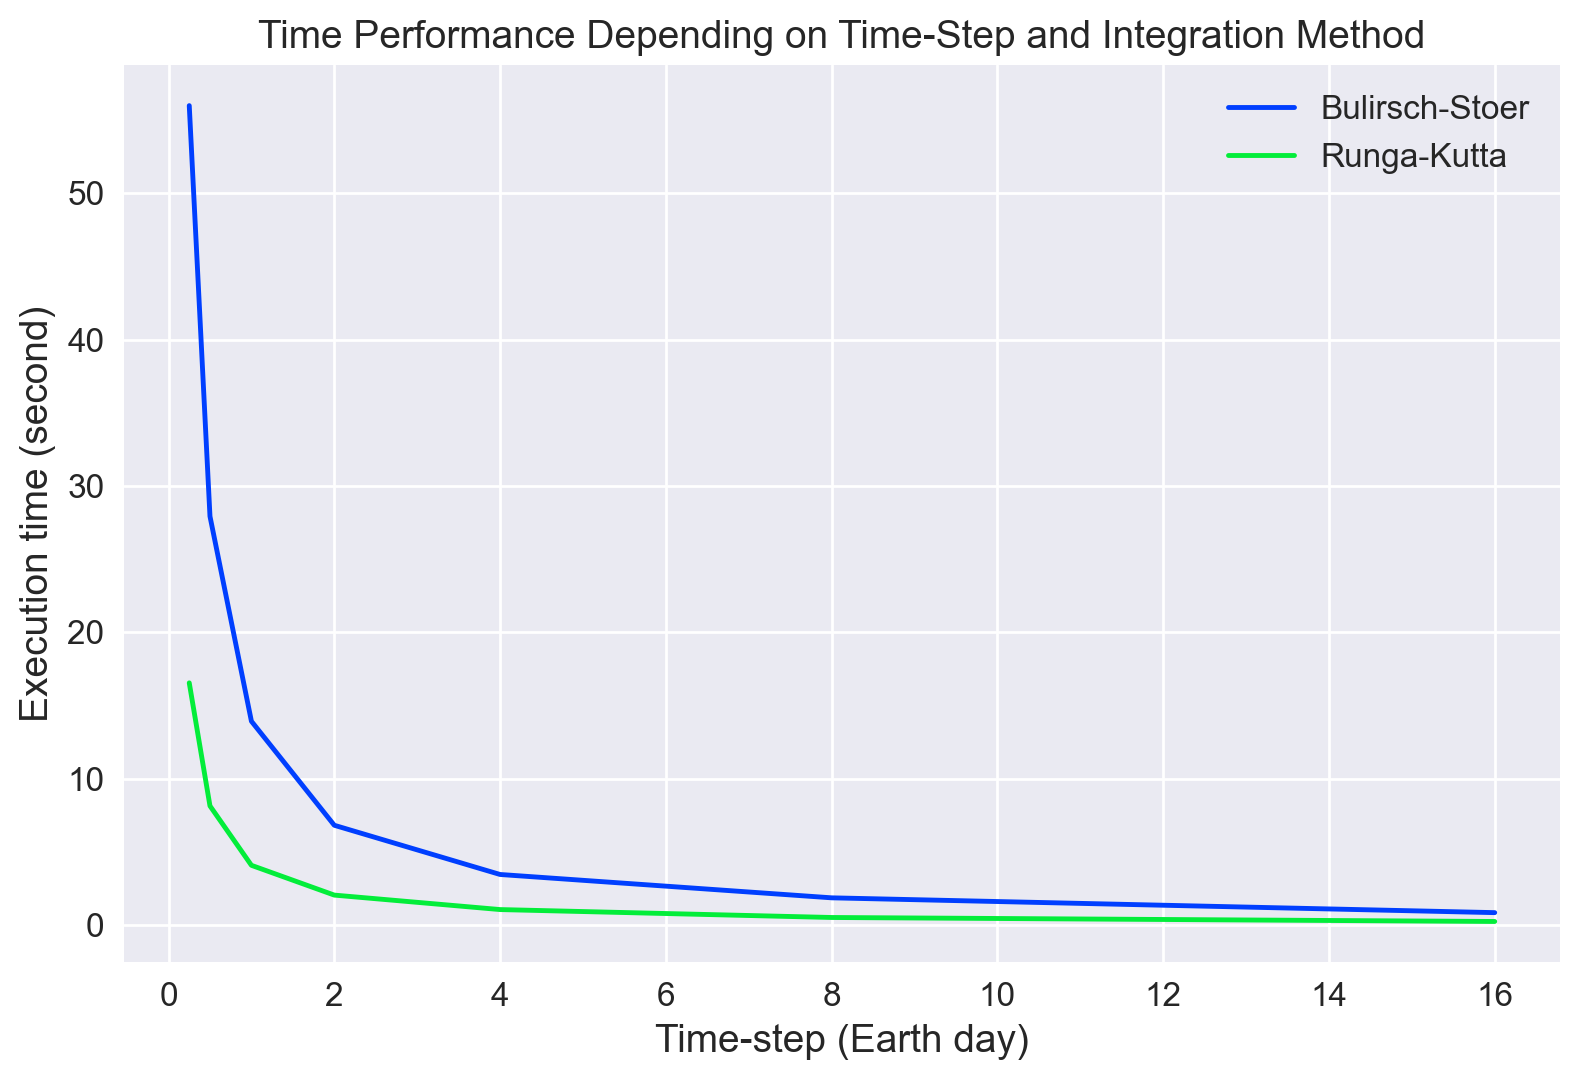

In [20]:
# plt.rcParams.update(plt.rcParamsDefault)
# %matplotlib inline
fig = plt.figure(dpi = 200)

ax = plt.subplot()
ax.plot(n_days_timestep, results["Bulirsch-Stoer_optimized"], label = "Bulirsch-Stoer")
ax.plot(n_days_timestep, results["Runga-Kutta_optimized"], label = "Runga-Kutta")
plt.legend(fontsize = '12')
# ax.tick_params('both', length=2, width=0.5)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
plt.ylabel("Execution time (second)", fontsize = '14')
plt.xlabel("Time-step (Earth day)", fontsize = '14')
plt.title("Time Performance Depending on Time-Step and Integration Method", fontsize = '14')
plt.tight_layout()
plt.savefig("analysis_exec_time_plot.png")
plt.show()

# now find accuracy by comapring with JBL results

In [6]:
horizons = pd.read_csv("horizons_data.csv")
display(horizons)

,position_sun,velocity_sun,position_earth,velocity_earth,position_jupiter,velocity_jupiter,position_saturn,velocity_saturn,position_neptune,velocity_neptune,position_uranus,velocity_uranus,position_venus,velocity_venus,position_mars,velocity_mars,position_mercury,velocity_mercury
0,"-1354630.417531006,14205.46299731827,31439.404...","0.001636302711538109,-0.01558286309774412,8.96...","-26824560.95823074,144897570.4171931,24130.011...","-29.81482351984199,-5.295918918751036,-0.00054...","722433460.0170468,156379381.3033296,-16811544....","-2.91321417813459,13.38384166879859,0.00966552...","1217477085.834203,-823540762.336208,-34153933....","4.872766511120636,7.982087638829929,-0.3327210...","4450807295.340764,-440224127.8807998,-93507774...","0.4993569179629754,5.441397105331187,-0.123578...","1998730572.785467,2158272361.448607,-17877998....","-5.046219886831179,4.309876668844167,0.0814038...","82594758.60642716,-69158163.57711238,-5762291....","22.0495169978705,26.878062380649,-0.9029101526...","7752583.519268439,233798755.7943932,4707746.51...","-23.29168054360782,2.985994216998675,0.6343688...","17640261.7363577,42055864.51549117,1724774.348...","-54.1312141613749,21.93301681426525,6.75905660..."
1,"-1191989.205285392,-434765.437029256,31461.244...","0.008441016159655652,-0.01221912155158748,-7.9...","-26002982.46493929,144560095.8366426,23246.040...","-29.83302263902714,-5.138481408411204,0.001105...","521378868.4191694,531392117.3350976,-13869271....","-9.472749551232376,9.769723278798496,0.1713482...","1344601253.411938,-556364183.2485545,-43861164...","3.15473832963897,8.905697033811052,-0.28001741...","4463254657.936563,-268350598.9444137,-97334375...","0.2902850778685768,5.457722901299887,-0.119080...","1834522305.517283,2288456660.822787,-15267196....","-5.363387289952575,3.942149642675445,0.0841563...","-108190731.4450878,-11890490.5881683,6048049.5...","3.52190129315428,-34.9897754152682,-0.68317050...","-45077763.77907523,-217519691.9117816,-3441546...","24.67035556744491,-2.734379283528958,-0.662061...","-42276107.97568034,29538994.10451555,6249351.6...","-38.64898908767687,-37.35110987200028,0.494364..."
2,"-858357.4692627767,-734059.4427518791,26871.82...","0.01239225283158465,-0.006370066685956891,-0.0...","-25011161.06399823,144379603.8784502,19218.300...","-29.8693434235105,-5.011245452060214,1.9038695...","158240228.4993888,742695871.8940198,-6620849.4...","-12.92829140406454,3.344604688615619,0.2753488...","1414390829.289237,-265535681.9343785,-51697060...","1.245527047631006,9.472517479542484,-0.2137150...","4469108959.084047,-96080306.37519486,-10101656...","0.0812682776407765,5.466565472199738,-0.114406...","1660711529.691558,2406659663.928277,-12576545....","-5.655240885430352,3.550363806166663,0.0864510...","69309797.55039349,81453091.34977832,-2893159.4...","-26.72905236891721,22.58228254060749,1.8530257...","-76997055.62154993,227929208.1934533,6685808.4...","-22.06062967840109,-5.600714510254003,0.423885...","-59432446.35572669,-21179836.03947781,3728524....","5.97675708521062,-43.89597490713352,-4.1339942..."
3,"-459937.6803933397,-827800.159168178,19720.000...","0.01242941479865781,0.0002919403916720422,-0.0...","-23954322.54720329,144390682.3016576,10805.206...","-29.86742871547168,-4.876447550720661,-0.00013...","-252797274.8118831,736836136.1665083,2601137.9...","-12.51289061094862,-3.620214132389417,0.295057...","1421887221.520328,36897023.79745989,-57254939....","-0.7846230459787606,9.634633268897028,-0.13585...","4468357872.83814,76332197.02779338,-104549779....","-0.1281091723456944,5.466420513151895,-0.11031...","1478127134.684886,2512147852.417339,-9819497.9...","-5.919693332028197,3.13609298038839,0.08833201...","9848413.711100679,-109119444.2803732,-2062823....","34.64024438472378,3.193837085184631,-1.9543758...","48375275.48156638,-208989022.189651,-5539972.4...","24.5181130702899,7.617643958050005,-0.44152353...","-35480911.92508472,-60197528.55757575,-1620011...","32.14197776486349,

Number of timesteps: 7300
Timestep: 0.0013688212927756654


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


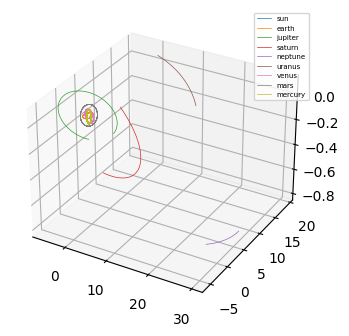

In [19]:
n_days_timestep = 0.5 # timestep in number of days
n_days_total = 365 * 10 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Runga-Kutta_optimized" # "Bulirsch-Stoer_optimized" #"Runga-Kutta_optimized"#"Runga-Kutta" "Bulisrsch-Stoer" 
args_bulirsch_stoer = [N, h, q, p]

n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer)

ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

In [21]:
index_row = n_days_total/365
print(index_row)

for i_body in range(len(bodies)):
    print(bodies[i_body])
    data_horizons = horizons["position_%s"%(bodies[i_body])]
    # print("Initial predicted:", data_horizons[0])
    # print("Initial simulation:", x[i_body][0] * AU, y[i_body][0] * AU, z[i_body][0] * AU)
    
    for time_y in range(1, int(n_days_total/365) + 1): # number of years
        position = data_horizons[time_y].split(",")
        jpl_x = float(position[0])
        jpl_y = float(position[1])
        jpl_z = float(position[2])
        my_x = x[i_body][int(time_y * 365 / n_days_timestep)] * AU
        my_y = y[i_body][int(time_y * 365 / n_days_timestep)] * AU
        my_z = z[i_body][int(time_y * 365 / n_days_timestep)] * AU
        
        
#         if bodies[i_body] == "mercury":
#             print("Predicted:", jpl_x, jpl_y, jpl_z)
#             print("Simulation:", my_x, my_y, my_z)

        p_diff_x = abs((my_x - jpl_x)/jpl_x)*100
        p_diff_y = abs((my_y - jpl_y)/jpl_y)*100
        p_diff_z = abs((my_z - jpl_z)/jpl_z)*100

        print("Year %i: x: %0.2f y: %0.2f z: %0.2f"%(time_y, p_diff_x, p_diff_y, p_diff_z))
        
    
    
#     position = data_horizons[index_row].split(",")
#     jpl_x = float(position[0])
#     jpl_y = float(position[1])
#     jpl_z = float(position[2])
#     # print("Predicted:", jpl_x, jpl_y, jpl_z)
#     my_x = x[i_body][n_days_total] * AU
#     my_y = y[i_body][n_days_total] * AU
#     my_z = z[i_body][n_days_total] * AU
#     # print("Simulation:", my_x, my_y, my_z)
    
#     p_diff_x = abs((my_x - jpl_x)/jpl_x)*100
#     p_diff_y = abs((my_y - jpl_y)/jpl_y)*100
#     p_diff_z = abs((my_z - jpl_z)/jpl_z)*100
    
#     print("percentage difference: \nx: %0.2f \ny: %0.2f \nz: %0.2f"%(p_diff_x, p_diff_y, p_diff_z))
    

10.0
sun
Year 1: x: 0.48 y: 0.01 z: 0.00
Year 2: x: 1.34 y: 0.01 z: 0.01
Year 3: x: 3.76 y: 0.02 z: 0.02
Year 4: x: 21.72 y: 0.04 z: 0.06
Year 5: x: 23.99 y: 0.07 z: 0.14
Year 6: x: 18.92 y: 0.17 z: 0.27
Year 7: x: 49.19 y: 0.73 z: 0.28
Year 8: x: 32.23 y: 0.13 z: 0.19
Year 9: x: 12.27 y: 0.05 z: 0.12
Year 10: x: 8.67 y: 0.25 z: 0.08
earth
Year 1: x: 1.43 y: 0.11 z: 26.77
Year 2: x: 3.01 y: 0.24 z: 38.05
Year 3: x: 4.64 y: 0.35 z: 80.21
Year 4: x: 6.45 y: 0.46 z: 267.19
Year 5: x: 8.28 y: 0.56 z: 579.97
Year 6: x: 10.33 y: 0.65 z: 289.98
Year 7: x: 12.60 y: 0.76 z: 424.98
Year 8: x: 14.73 y: 0.86 z: 2010.76
Year 9: x: 16.84 y: 0.96 z: 415.81
Year 10: x: 19.16 y: 1.07 z: 248.76
jupiter
Year 1: x: 0.00 y: 0.00 z: 0.01
Year 2: x: 0.03 y: 0.00 z: 0.03
Year 3: x: 0.03 y: 0.00 z: 0.11
Year 4: x: 0.01 y: 0.00 z: 0.02
Year 5: x: 0.01 y: 0.02 z: 0.01
Year 6: x: 0.01 y: 0.01 z: 0.01
Year 7: x: 0.01 y: 0.00 z: 0.01
Year 8: x: 0.03 y: 0.01 z: 0.02
Year 9: x: 0.06 y: 0.01 z: 1.02
Year 10: x: 0.01 y

# test new function run_simulation_save that instead of storing values in arrays, save every timestep in files

Number of timesteps: 3650
Timestep: 0.0027376425855513307


,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-1.355e+06,1.421e+04,3.144e+04,0.002,-0.016,8.962e-05,1.989e+30
earth,-2.682e+07,1.449e+08,2.413e+04,29.815,-5.296,-5.494e-04,5.972e+24
jupiter,7.224e+08,1.564e+08,-1.681e+07,-2.913,13.384,9.666e-03,1.899e+27
saturn,1.217e+09,-8.235e+08,-3.415e+07,4.873,7.982,-3.327e-01,5.683e+26
neptune,4.451e+09,-4.402e+08,-9.351e+07,0.499,5.441,-1.236e-01,1.024e+26
uranus,1.999e+09,2.158e+09,-1.788e+07,-5.046,4.310,8.140e-02,8.681e+25
venus,8.259e+07,-6.916e+07,-5.762e+06,22.050,26.878,-9.029e-01,4.867e+24
mars,7.753e+06,2.338e+08,4.708e+06,-23.292,2.986,6.344e-01,6.416e+23
mercury,1.764e+07,4.206e+07,1.725e+06,-54.131,21.933,6.759e+00,3.285e+23


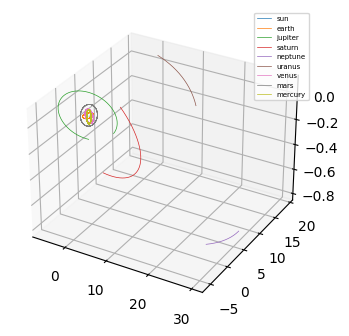

In [39]:
n_days_timestep = 1 # timestep in number of days
n_days_total = 365 * 10 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1


folder = "tmp"
step_save = 5

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta_optimized"#"Runga-Kutta" "Bulisrsch-Stoer" 
args_bulirsch_stoer = [N, h, q, p]

n_bodies, bodies, exec_time = run_simulation_save(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, folder, step_save)

x, y, z = get_positions_from_files(folder, list(range(0, n_days_total + 1, step_save)), n_bodies)

ax = plt.figure(dpi = 100).add_subplot(projection='3d')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

In [ ]:















Predicted: -1191989.205285392 -434765.437029256 31461.24454779254

Simulation: -1186974.5053155434 -433776.8565219012 31466.070328973245
    
Simulation: -1186245.3140239713 -434833.6463915843 31459.22237401746



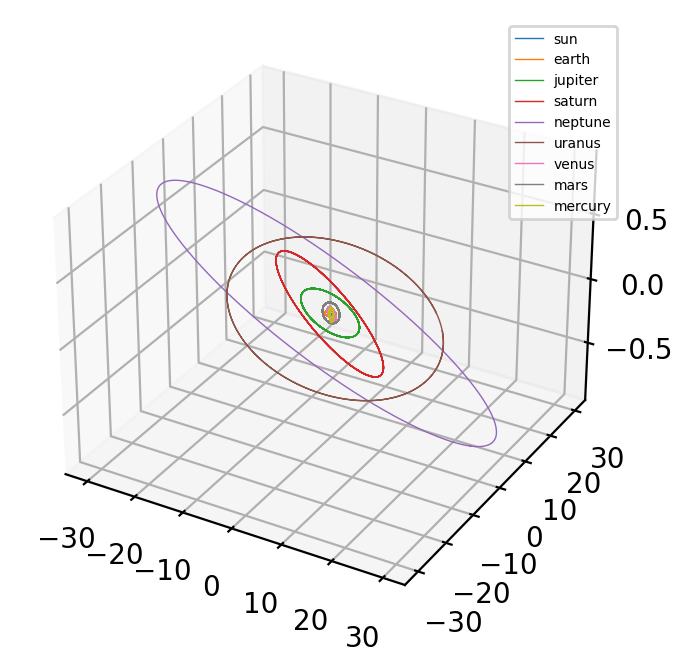

In [108]:
ax = plt.figure(dpi = 200).add_subplot(projection='3d')
# ax.set_aspect('equal')
for i in range(n_bodies):
    ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
# ax.set_zlim(0.0001, 0.0003)
ax.legend(fontsize="5")
# plt.savefig("plot_bulirsch_stoer.png")
# plt.savefig("earth_trajectory/earth_trajectory_%i_body_system_multiple_orbits.png"%(n_bodies))
plt.show()